# Fantasy Draft Recommender System

This notebook will help you win your fantasy draft -- or make you lose miserably. TBD

This notebook utilizes reinforcment learning on previous NFL drafts to help determine the optimal draft day strategy.

Pulls data from here: https://github.com/nflverse/nfl_data_py

In [124]:
import nfl_data_py as nfl
import pandas as pd

# Pull weekly data for the last few seasons
years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]

In [125]:
# Pull the core dataframes
weekly_df = nfl.import_weekly_data(years)
seasonal_df = nfl.import_seasonal_data(years)
rosters_df = nfl.import_weekly_rosters(years)
draft_df = nfl.import_draft_picks(years)
combine_df = nfl.import_combine_data(years)
id_map = nfl.import_ids()
pbp = nfl.import_pbp_data(years)

Downcasting floats.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


In [126]:
def show_info(df, name):
    print(f"--- {name} ---")
    print("columns:", list(df.columns))
    print("dtypes:\n", df.dtypes)
    print("head:\n", df.head(2))
    print()

show_info(weekly_df, "weekly_df")
show_info(rosters_df, "rosters_df")

keys = ['player_id', 'season', 'week']
print("keys present in weekly_df:", [k for k in keys if k in weekly_df.columns])
print("keys present in rosters_df:", [k for k in keys if k in rosters_df.columns])


--- weekly_df ---
columns: ['player_id', 'player_name', 'player_display_name', 'position', 'position_group', 'headshot_url', 'recent_team', 'season', 'week', 'season_type', 'opponent_team', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch', 'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share', 'wopr', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr']
dtypes:
 player_id                       obje

weekly x rosters join: {'both': 38568, 'left_only': 0, 'right_only': 0}
season merge counts: {'both': 38545, 'left_only': 23, 'right_only': 0}
draft merge counts: {'left_only': 34046, 'both': 4522, 'right_only': 0}
combine merge counts: {'left_only': 38568, 'right_only': 0, 'both': 0}
Final merged shape: (38568, 163)
weekly_df columns:
Index(['player_id', 'player_name', 'player_display_name', 'position',
       'position_group', 'headshot_url', 'recent_team', 'season', 'week',
       'season_type', 'opponent_team', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',
       'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
       'reception

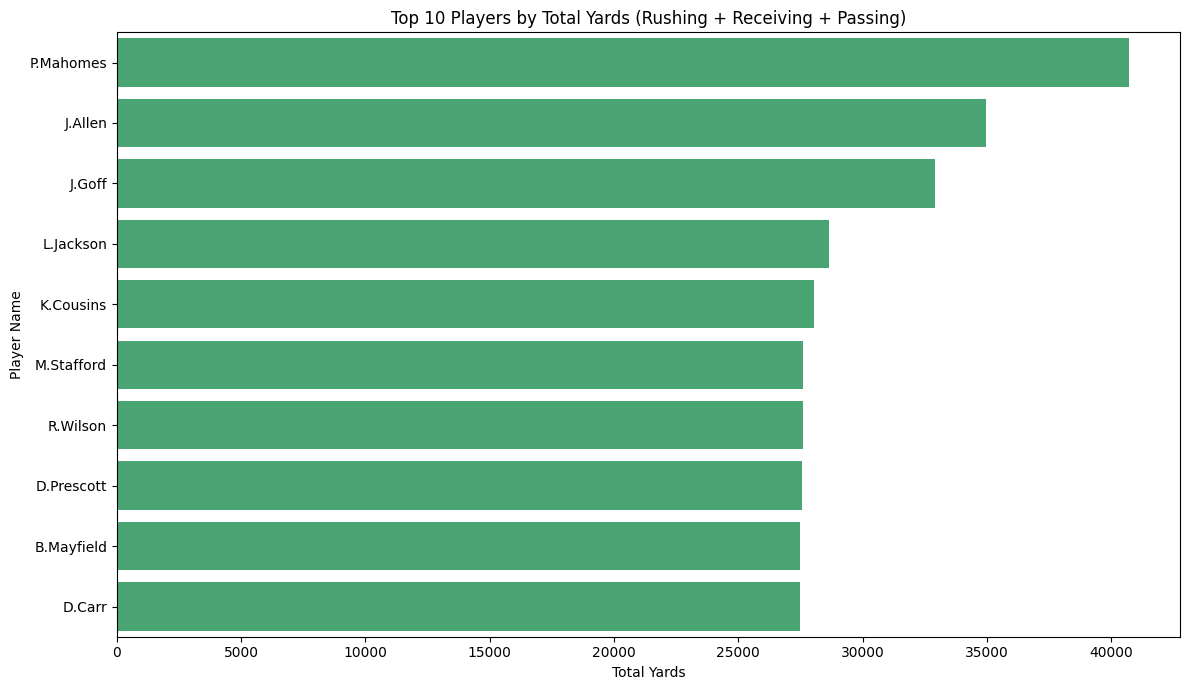

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Your original code for cleaning and merging ---

def ensure_cols(df):
    rename_map = {}
    alt_names = {
        'player_id': ['nflverse_player_id', 'nfl_id', 'gsis_id', 'pfr_id', 'player'],
        'week': ['week_id', 'game_week'],
        'season': ['season_year']
    }
    for canonical, alts in alt_names.items():
        if canonical not in df.columns:
            for alt in alts:
                if alt in df.columns:
                    rename_map[alt] = canonical
    if rename_map:
        df = df.rename(columns=rename_map)
        print("Renamed columns:", rename_map)

    for k in ['season', 'week']:
        if k in df.columns:
            try:
                df[k] = df[k].astype('Int64')
            except Exception:
                pass

    df = df.loc[:, ~df.columns.duplicated()]
    return df

weekly_df = ensure_cols(weekly_df)
rosters_df = ensure_cols(rosters_df)
seasonal_df = ensure_cols(seasonal_df)
draft_df = ensure_cols(draft_df)
combine_df = ensure_cols(combine_df)

def add_player_id(df, id_map):
    if 'player_id' not in df.columns:
        for key in ['pfr_id', 'gsis_id', 'nfl_id', 'combine_id']:
            if key in df.columns and key in id_map.columns:
                df = df.merge(
                    id_map[[key, 'nflverse_player_id']],
                    on=key,
                    how='left'
                )
                df = df.rename(columns={'nflverse_player_id': 'player_id'})
                break
    df = df.loc[:, ~df.columns.duplicated()]
    return df

weekly_df = add_player_id(weekly_df, id_map)
rosters_df = add_player_id(rosters_df, id_map)
seasonal_df = add_player_id(seasonal_df, id_map)
draft_df = add_player_id(draft_df, id_map)
combine_df = add_player_id(combine_df, id_map)

def safe_merge(left, right, **kwargs):
    left = left.loc[:, ~left.columns.duplicated()]
    right = right.loc[:, ~right.columns.duplicated()]
    merged = pd.merge(left, right, **kwargs)
    merged = merged.loc[:, ~merged.columns.duplicated()]
    return merged

merged_df = safe_merge(
    weekly_df,
    rosters_df,
    on=['player_id', 'season', 'week'],
    how='left',
    suffixes=('_weekly', '_roster'),
    indicator=True
)
print("weekly x rosters join:", merged_df['_merge'].value_counts().to_dict())
merged_df.drop(columns=['_merge'], inplace=True)

seasonal_df = seasonal_df.drop(columns=['player_name', 'position', 'team_abbr'], errors='ignore')
merged_df = safe_merge(
    merged_df,
    seasonal_df,
    on=['player_id', 'season'],
    how='left',
    suffixes=('', '_season'),
    indicator=True
)
print("season merge counts:", merged_df['_merge'].value_counts().to_dict())
merged_df.drop(columns=['_merge'], inplace=True)

draft_df = draft_df.rename(columns={'round': 'draft_round', 'pick': 'draft_pick'})
merged_df = safe_merge(
    merged_df,
    draft_df[['player_id', 'season', 'draft_round', 'draft_pick']],
    on=['player_id', 'season'],
    how='left',
    indicator=True
)
print("draft merge counts:", merged_df['_merge'].value_counts().to_dict())
merged_df.drop(columns=['_merge'], inplace=True)

merged_df = safe_merge(
    merged_df,
    combine_df,
    on='player_id',
    how='left',
    indicator=True
)
print("combine merge counts:", merged_df['_merge'].value_counts().to_dict())
merged_df.drop(columns=['_merge'], inplace=True)

print("Final merged shape:", merged_df.shape)

# --- 6. Aggregate 40+ yard plays from pbp ---

def aggregate_long_plays(pbp_df):
    # Ensure yards_gained and pass_length are numeric, fill NaNs with 0
    pbp_df['yards_gained'] = pd.to_numeric(pbp_df.get('yards_gained', 0), errors='coerce').fillna(0)
    pbp_df['pass_length'] = pd.to_numeric(pbp_df.get('pass_length', 0), errors='coerce').fillna(0)

    # Long plays flags (>=40 yards)
    pbp_df['long_pass_completion_40'] = (
        (pbp_df['passer_player_id'].notna()) & 
        (pbp_df['yards_gained'] >= 40)
    ).astype(int)

    pbp_df['long_pass_td_40'] = (
        (pbp_df['passer_player_id'].notna()) & 
        (pbp_df['touchdown'] == 1) & 
        (pbp_df['yards_gained'] >= 40)
    ).astype(int)

    pbp_df['long_rush_40'] = (
        (pbp_df['rusher_player_id'].notna()) & 
        (pbp_df['yards_gained'] >= 40)
    ).astype(int)

    pbp_df['long_rush_td_40'] = (
        (pbp_df['rusher_player_id'].notna()) & 
        (pbp_df['touchdown'] == 1) & 
        (pbp_df['yards_gained'] >= 40)
    ).astype(int)

    pbp_df['long_receive_40'] = (
        (pbp_df['receiver_player_id'].notna()) & 
        (pbp_df['yards_gained'] >= 40)
    ).astype(int)

    pbp_df['long_receive_td_40'] = (
        (pbp_df['receiver_player_id'].notna()) & 
        (pbp_df['touchdown'] == 1) & 
        (pbp_df['yards_gained'] >= 40)
    ).astype(int)

    # Aggregate sums per player, season, week
    agg = pbp_df.groupby(['season', 'week']).agg({
        # Passing long plays - aggregate by passer
        'passer_player_id': 'first',  # placeholder, will fix below
        'long_pass_completion_40': 'sum',
        'long_pass_td_40': 'sum',

        # Rushing long plays - aggregate by rusher
        'rusher_player_id': 'first',  # placeholder, fix below
        'long_rush_40': 'sum',
        'long_rush_td_40': 'sum',

        # Receiving long plays - aggregate by receiver
        'receiver_player_id': 'first',  # placeholder, fix below
        'long_receive_40': 'sum',
        'long_receive_td_40': 'sum',
    }).reset_index()

    # The above aggregated by season/week but player IDs can be many per week
    # Instead, we want aggregation by player_id + season + week for all roles.
    # So aggregate separately per player role and then combine.

    # Aggregate passing long plays by passer_player_id
    pass_agg = pbp_df.groupby(['season', 'week', 'passer_player_id']).agg({
        'long_pass_completion_40': 'sum',
        'long_pass_td_40': 'sum'
    }).reset_index().rename(columns={'passer_player_id':'player_id'})

    # Aggregate rushing long plays by rusher_player_id
    rush_agg = pbp_df.groupby(['season', 'week', 'rusher_player_id']).agg({
        'long_rush_40': 'sum',
        'long_rush_td_40': 'sum'
    }).reset_index().rename(columns={'rusher_player_id':'player_id'})

    # Aggregate receiving long plays by receiver_player_id
    rec_agg = pbp_df.groupby(['season', 'week', 'receiver_player_id']).agg({
        'long_receive_40': 'sum',
        'long_receive_td_40': 'sum'
    }).reset_index().rename(columns={'receiver_player_id':'player_id'})

    # Merge the three role aggregations together on season, week, player_id
    combined = pd.merge(pass_agg, rush_agg, on=['season','week','player_id'], how='outer')
    combined = pd.merge(combined, rec_agg, on=['season','week','player_id'], how='outer')

    # Fill NaNs with 0 for counts
    combined[['long_pass_completion_40', 'long_pass_td_40',
              'long_rush_40', 'long_rush_td_40',
              'long_receive_40', 'long_receive_td_40']] = combined[[
                  'long_pass_completion_40', 'long_pass_td_40',
                  'long_rush_40', 'long_rush_td_40',
                  'long_receive_40', 'long_receive_td_40']].fillna(0)

    return combined



# pbp must be loaded prior, e.g. pbp = nfl.import_pbp_data([2024])
agg_long_plays = aggregate_long_plays(pbp)

# --- 7. Merge into merged_df ---

merged_df = merged_df.rename(columns={'season_x':'season'}) if 'season_x' in merged_df.columns else merged_df

merged_df = pd.merge(
    merged_df,
    agg_long_plays,
    on=['season', 'week', 'player_id'],
    how='left'
)

long_cols = [
    'long_pass_completion_40', 'long_pass_td_40',
    'long_rush_40', 'long_rush_td_40',
    'long_receive_40', 'long_receive_td_40'  # corrected names
]

merged_df[long_cols] = merged_df[long_cols].fillna(0)

for df_name, df in [('weekly_df', weekly_df), ('pbp', pbp), ('seasonal_df', seasonal_df)]:
    print(f"{df_name} columns:")
    print(df.columns)
    print('-' * 40)

# Add total_fumbles_lost column to weekly_df first
weekly_df['total_fumbles_lost'] = (
    weekly_df['sack_fumbles_lost'].fillna(0) +
    weekly_df['rushing_fumbles_lost'].fillna(0) +
    weekly_df['receiving_fumbles_lost'].fillna(0)
)

weekly_df['total_two_point_conversions'] = (
    weekly_df['passing_2pt_conversions'].fillna(0) +
    weekly_df['rushing_2pt_conversions'].fillna(0) +
    weekly_df['receiving_2pt_conversions'].fillna(0)
)

merged_df = merged_df.merge(
    weekly_df[['player_id', 'season', 'week', 'total_two_point_conversions']],
    on=['player_id', 'season', 'week'],
    how='left'
)

merged_df['total_two_point_conversions'] = merged_df['total_two_point_conversions'].fillna(0)

# Then when merging weekly_df into merged_df (or if already merged, add it explicitly)
merged_df = merged_df.merge(
    weekly_df[['player_id', 'season', 'week', 'total_fumbles_lost']],
    on=['player_id', 'season', 'week'],
    how='left'
)

# --- 8. Update fantasy points calculation ---

def compute_fantasy_points(df):
    def get_col_or_zero(df, col):
        if col in df.columns:
            return df[col].fillna(0)
        else:
            return pd.Series(0, index=df.index)

    passing_yards = get_col_or_zero(df, 'passing_yards')
    passing_tds = get_col_or_zero(df, 'passing_tds')
    interceptions = get_col_or_zero(df, 'interceptions')
    rushing_yards = get_col_or_zero(df, 'rushing_yards')
    rushing_tds = get_col_or_zero(df, 'rushing_tds')
    receptions = get_col_or_zero(df, 'receptions')
    receiving_yards = get_col_or_zero(df, 'receiving_yards')
    receiving_tds = get_col_or_zero(df, 'receiving_tds')
    fumbles_lost = get_col_or_zero(df, 'total_fumbles_lost')
    sacks = get_col_or_zero(df, 'sacks')
    two_pt_conversions = get_col_or_zero(df, 'two_point_conversions')
    pick_six = get_col_or_zero(df, 'pick_six')
    long_pass_cmp_40 = get_col_or_zero(df, 'long_pass_completion_40')
    long_pass_td_40 = get_col_or_zero(df, 'long_pass_td_40')
    long_rush_40 = get_col_or_zero(df, 'long_rush_40')
    long_rush_td_40 = get_col_or_zero(df, 'long_rush_td_40')
    long_rec_40 = get_col_or_zero(df, 'long_receive_40')
    long_rec_td_40 = get_col_or_zero(df, 'long_receive_td_40')
    sack_yards = get_col_or_zero(df, 'sack_yards')

    df['fantasy_points_custom'] = (
        (passing_yards / 25) +
        (passing_tds * 6) +
        (interceptions * -2) +
        (rushing_yards / 10) +
        (rushing_tds * 6) +
        (receptions * 0.5) +
        (receiving_yards / 10) +
        (receiving_tds * 6) +
        (fumbles_lost * -2) +
        (sacks * -1) +
        # (sack_yards / -10) +
        (two_pt_conversions * 2) +
        (pick_six * -6) +
        (long_pass_cmp_40 * 1) +
        (long_pass_td_40 * 4) +
        (long_rush_40 * 2) +
        (long_rush_td_40 * 4) +
        (long_rec_40 * 2) +
        (long_rec_td_40 * 4)
    )
    return df


merged_df = compute_fantasy_points(merged_df)

# --- 9. Visualization example: Top 10 Players by Total Yards ---

merged_df['total_yards'] = (
    merged_df['rushing_yards'].fillna(0) +
    merged_df['receiving_yards'].fillna(0) +
    merged_df['passing_yards'].fillna(0)
)

if 'player_name_weekly' in merged_df.columns:
    merged_df['player_name'] = merged_df['player_name_weekly']
elif 'player_name_roster' in merged_df.columns:
    merged_df['player_name'] = merged_df['player_name_roster']
else:
    merged_df['player_name'] = "Unknown"
       
top_players = (
    merged_df.groupby('player_name', as_index=False)['total_yards']
    .sum()
    .sort_values(by='total_yards', ascending=False)
    .head(10)
)

plt.figure(figsize=(12, 7))
sns.barplot(data=top_players, y='player_name', x='total_yards', color='mediumseagreen')
plt.title("Top 10 Players by Total Yards (Rushing + Receiving + Passing)")
plt.xlabel("Total Yards")
plt.ylabel("Player Name")
plt.tight_layout()
plt.show()


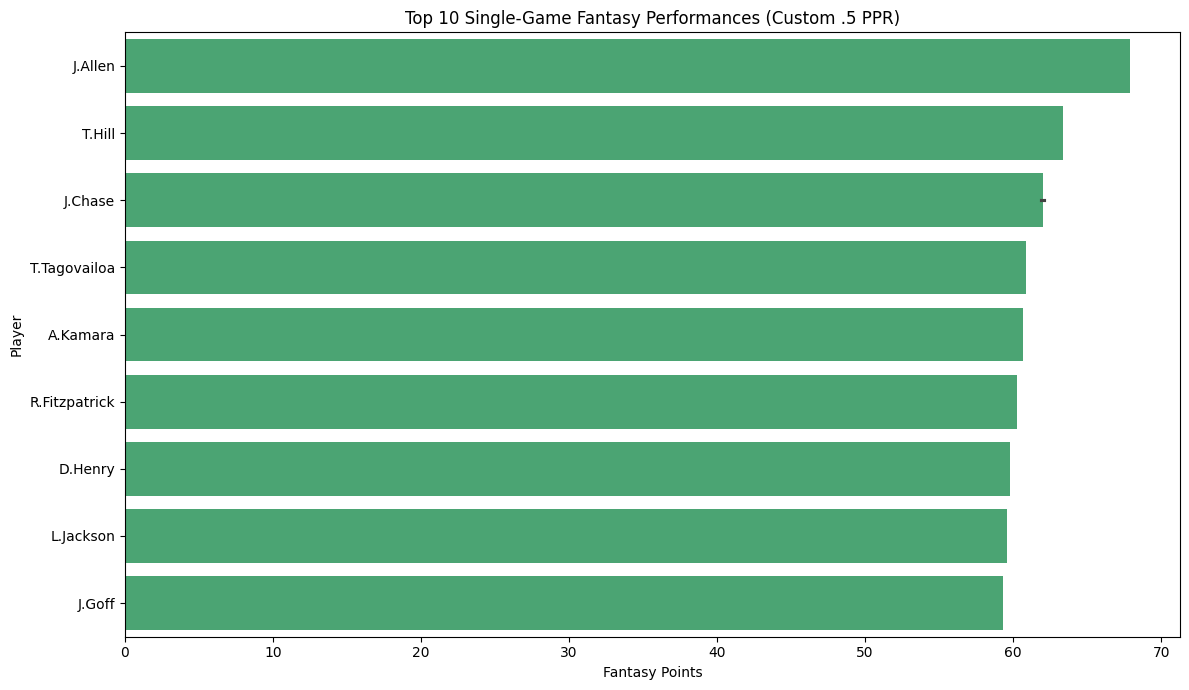

In [153]:
top_custom_fantasy = merged_df.sort_values(by='fantasy_points_custom', ascending=False).head(10)

plt.figure(figsize=(12, 7))
sns.barplot(data=top_custom_fantasy, y='player_name', x='fantasy_points_custom', color='mediumseagreen')
plt.title('Top 10 Single-Game Fantasy Performances (Custom .5 PPR)')
plt.xlabel('Fantasy Points')
plt.ylabel('Player')
plt.tight_layout()
plt.show()


Using latest season: 2024
Columns in merged_df: Index(['player_id', 'player_name_weekly', 'player_display_name',
       'position_weekly', 'position_group', 'headshot_url_weekly',
       'recent_team', 'season', 'week', 'season_type',
       ...
       'long_pass_completion_40', 'long_pass_td_40', 'long_rush_40',
       'long_rush_td_40', 'long_receive_40', 'long_receive_td_40',
       'total_two_point_conversions', 'total_fumbles_lost_y',
       'fantasy_points_custom', 'total_yards'],
      dtype='object', length=173)
Rows in latest season up to week 17: 5024
Unique players with points: 591
Top 50 player_ids: ['00-0034796', '00-0036442', '00-0034857', '00-0034855', '00-0033106', '00-0039910', '00-0034844', '00-0036900', '00-0034869', '00-0036389', '00-0039732', '00-0032764', '00-0033873', '00-0035228', '00-0039139', '00-0037834', '00-0036264', '00-0038542', '00-0036355', '00-0036322', '00-0035700', '00-0037248', '00-0036963', '00-0037840', '00-0023459', '00-0039040', '00-0039893', '0

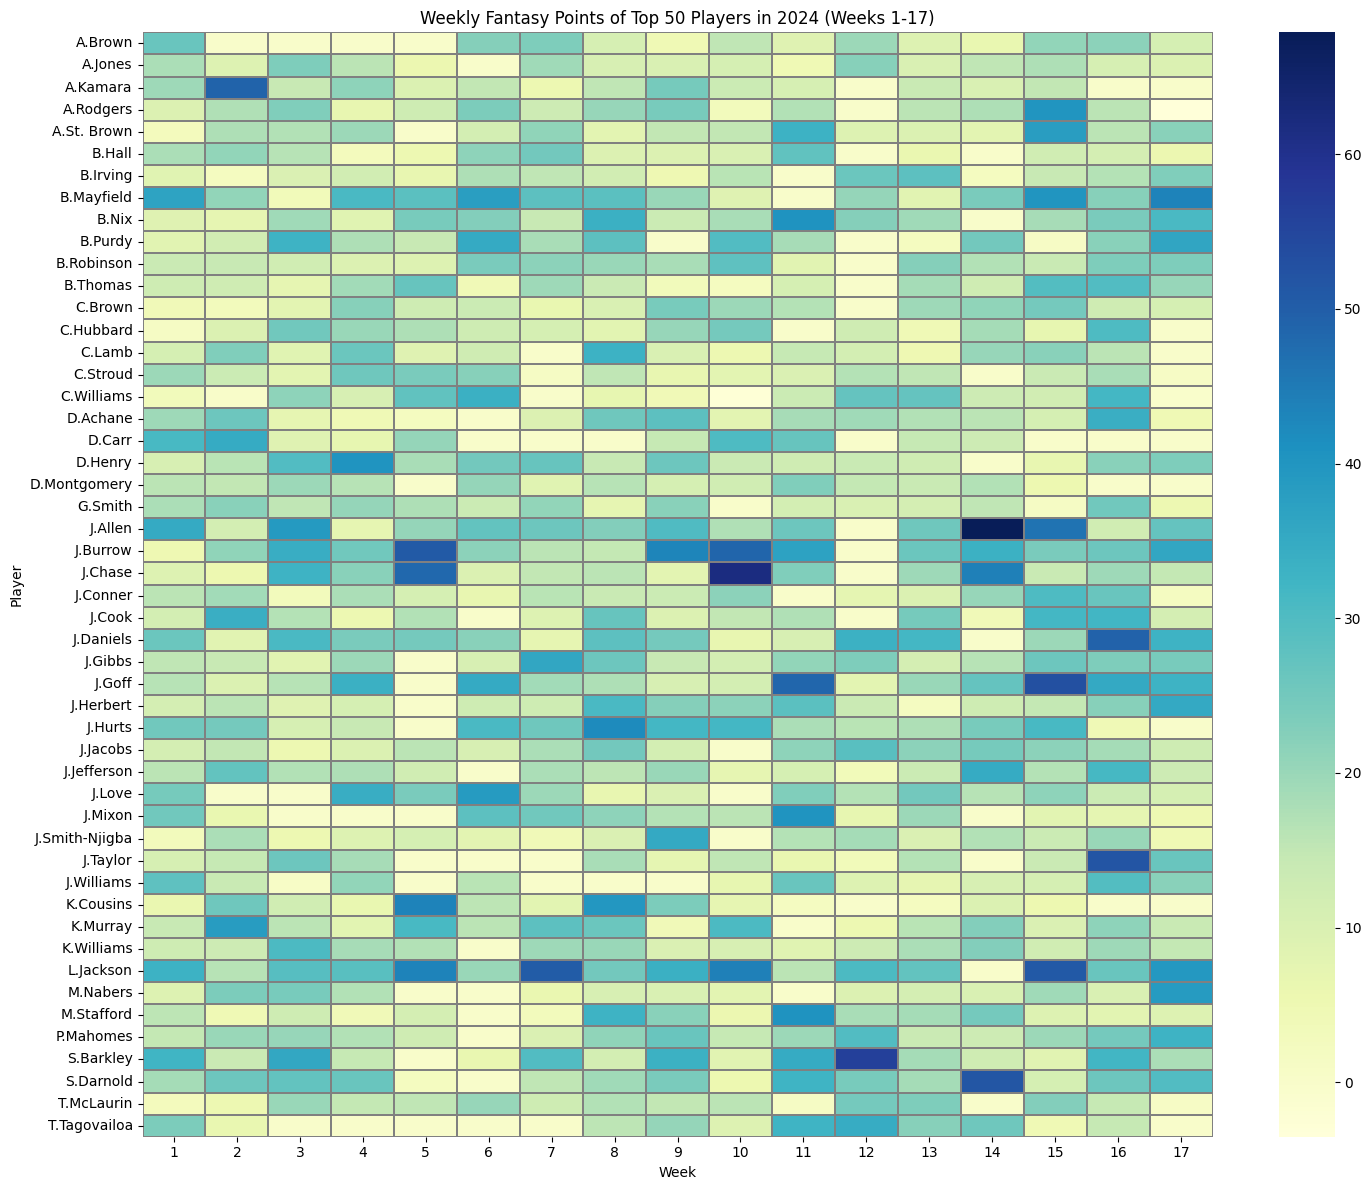

In [154]:
max_season = 2024
print("Using latest season:", max_season)

print("Columns in merged_df:", merged_df.columns)

df_latest = merged_df[(merged_df['season'] == max_season) & (merged_df['week'] <= 17)].copy()
print(f"Rows in latest season up to week 17: {len(df_latest)}")

df_latest = compute_fantasy_points(df_latest)

total_points = df_latest.groupby('player_id')['fantasy_points_custom'].sum().reset_index()
print("Unique players with points:", len(total_points))

top_50_ids = total_points.nlargest(50, 'fantasy_points_custom')['player_id'].tolist()
print("Top 50 player_ids:", top_50_ids)

top_50_df = df_latest[df_latest['player_id'].isin(top_50_ids)].copy()
print(f"Rows for top 50 players up to week 17: {len(top_50_df)}")

weekly_points = top_50_df.groupby(['week', 'player_id', 'player_name_weekly'])['fantasy_points_custom'].sum().reset_index()
print("Weekly points rows:", len(weekly_points))

pivot = weekly_points.pivot(index='player_name_weekly', columns='week', values='fantasy_points_custom').fillna(0)
print("Pivot shape:", pivot.shape)

if pivot.empty:
    print("Pivot table is empty, no data to plot.")
else:
    plt.figure(figsize=(15, 12))
    sns.heatmap(pivot, cmap='YlGnBu', linewidths=0.3, linecolor='gray')
    plt.title(f"Weekly Fantasy Points of Top 50 Players in {max_season} (Weeks 1-17)")
    plt.xlabel("Week")
    plt.ylabel("Player")
    plt.tight_layout()
    plt.show()


In [155]:
agg_points = top_50_df.groupby('player_name_weekly')['fantasy_points_custom'].sum().sort_values(ascending=False)
print("\nAggregated fantasy points for Top 50 players (Weeks 1-17):")
print(agg_points)

agg_all = top_50_df.groupby('player_name_weekly', as_index=False).sum(numeric_only=True).sort_values('fantasy_points_custom', ascending=False)
print("\nAggregated sums for Top 50 players (Weeks 1-17):")
print(agg_all)





Aggregated fantasy points for Top 50 players (Weeks 1-17):
player_name_weekly
L.Jackson         514.399999
J.Burrow          463.839999
J.Allen           442.339999
B.Mayfield        402.160000
J.Goff            394.720000
J.Daniels         380.599999
S.Barkley         365.799999
J.Chase           362.899999
S.Darnold         358.320000
J.Hurts           349.120000
B.Nix             326.160001
D.Henry           311.800000
P.Mahomes         310.520001
K.Murray          302.360000
J.Gibbs           301.400000
B.Purdy           300.860000
J.Love            285.100000
B.Robinson        278.900000
J.Herbert         277.360000
J.Jefferson       275.080000
J.Jacobs          272.000000
J.Cook            265.900001
A.St. Brown       263.979999
K.Williams        261.099998
A.Rodgers         256.620000
D.Achane          250.800001
B.Thomas          242.700000
M.Stafford        240.580001
G.Smith           237.680000
A.Kamara          237.300000
J.Conner          234.300000
C.Brown           230.

In [231]:
# Aggregate total fantasy points per player over all weeks
total_points = top_50_df.groupby('player_name')['fantasy_points_custom'].sum()

# Sort players by total points descending
sorted_players = total_points.sort_values(ascending=False).index

# Aggregate weekly points (as before)
weekly_points = top_50_df.groupby(['player_name', 'week'], as_index=False)['fantasy_points_custom'].sum()

# Pivot to get player x week table
pivot_df = weekly_points.pivot(index='player_name', columns='week', values='fantasy_points_custom').fillna(0)

# Reorder rows by total points (descending)
pivot_df = pivot_df.loc[sorted_players]

print(pivot_df)


week               1      2          3      4          5      6      7   \
player_name                                                               
L.Jackson       33.12  16.38  28.980000  28.64  43.420000  19.92  50.44   
J.Burrow         5.06  21.22  34.360000  25.28  50.780000  21.82  15.94   
J.Allen         35.18  11.76  38.920001   7.30  20.640000  27.40  26.02   
B.Mayfield      36.66  20.80   3.520000  30.88  28.400000  37.90  28.00   
J.Goff          16.38   9.78  16.560000  33.68   0.000000  35.10  18.80   
J.Daniels       26.16   8.44  31.060000  24.02  24.720000  21.96   7.24   
S.Barkley       32.20  13.60  35.600000  14.60   0.000000   6.40  29.70   
J.Chase          9.20   5.50  32.800000  22.00  48.299999   9.70  15.10   
S.Darnold       18.62  25.92  27.240000  26.50   2.260000   0.00  15.26   
J.Hurts         25.42  24.82  10.940000  14.32   0.000000  30.86  25.76   
B.Nix            9.02   7.34  19.340000   8.70  24.140000  22.74  14.06   
D.Henry         10.60  16

In [229]:
import nfl_data_py as nfl
import pandas as pd

def calculate_sos(year):
    """
    Calculates the Strength of Schedule (SOS) for all NFL teams in a given year.

    SOS is calculated as the average winning percentage of a team's opponents,
    excluding games played against the team itself to avoid bias.

    Args:
        year (int): The NFL season year (e.g., 2023).

    Returns:
        pd.DataFrame: A DataFrame with 'team', 'strength_of_schedule', and 'win_pct'
                      columns, sorted by SOS in descending order.
    """
    print(f"Calculating Strength of Schedule for the {year} NFL season...")

    try:
        # Step 1: Import play-by-play data for the specified year
        # This dataset contains information about each play, but we'll extract game-level outcomes.
        pbp_df = nfl.import_pbp_data([year])
        
        # Check if the DataFrame is empty, which indicates data is not available for the year
        if pbp_df.empty:
            print(f"Data not available for the {year} season. Please try a past season (e.g., 2023).")
            return pd.DataFrame() # Return an empty DataFrame

        print("Play-by-play data loaded successfully.")

        # Step 2: Extract unique game outcomes to get match results
        # We need game_id, season, week, teams involved, and final scores.
        games = pbp_df[['game_id', 'season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']].drop_duplicates().reset_index(drop=True)
        print(f"Extracted {len(games)} unique games.")

        # Determine game outcomes (win/loss/tie) for easier calculation
        games['home_win'] = (games['home_score'] > games['away_score']).astype(int)
        games['away_win'] = (games['away_score'] > games['home_score']).astype(int)
        games['tie'] = (games['home_score'] == games['away_score']).astype(int)

        # Step 3: Calculate the final winning percentage for each team in the season
        team_records = {}
        # Get all unique teams that played in the season
        all_teams = pd.concat([games['home_team'], games['away_team']]).unique()

        for team in all_teams:
            # Games where the current team was the home team
            team_games_home = games[(games['home_team'] == team) & (games['season'] == year)]
            # Games where the current team was the away team
            team_games_away = games[(games['away_team'] == team) & (games['season'] == year)]

            # Sum up wins (1 point for win, 0.5 for tie)
            wins = team_games_home['home_win'].sum() + team_games_away['away_win'].sum() + \
                   (team_games_home['tie'].sum() * 0.5) + (team_games_away['tie'].sum() * 0.5)
            
            # Total games played by the team
            total_games = len(team_games_home) + len(team_games_away)
            
            # Calculate win percentage, handle division by zero for teams with no games (unlikely in NFL)
            win_percentage = wins / total_games if total_games > 0 else 0
            team_records[team] = win_percentage
        
        # Convert the dictionary of team records to a DataFrame for easy merging and lookup
        team_win_pct_df = pd.DataFrame.from_dict(team_records, orient='index', columns=['win_pct']).reset_index()
        team_win_pct_df.rename(columns={'index': 'team'}, inplace=True)
        print("Team winning percentages calculated.")
        
        # Step 4: Calculate Strength of Schedule for each team
        sos_data = []
        for team in team_win_pct_df['team']:
            # Get all opponents for the current team in the season
            # Find opponents when 'team' was home
            opponents_as_home = games[(games['home_team'] == team) & (games['season'] == year)]['away_team'].tolist()
            # Find opponents when 'team' was away
            opponents_as_away = games[(games['away_team'] == team) & (games['season'] == year)]['home_team'].tolist()
            
            all_opponents = opponents_as_home + opponents_as_away

            opponent_win_pcts = []
            for opp in all_opponents:
                # Find games where the opponent 'opp' played, EXCLUDING games against the current 'team'
                opp_games_home = games[(games['home_team'] == opp) & (games['season'] == year) & (games['away_team'] != team)]
                opp_games_away = games[(games['away_team'] == opp) & (games['season'] == year) & (games['home_team'] != team)]

                # Calculate the opponent's winning percentage based on *their* games, excluding the current team's games
                opp_wins = opp_games_home['home_win'].sum() + opp_games_away['away_win'].sum() + \
                           (opp_games_home['tie'].sum() * 0.5) + (opp_games_away['tie'].sum() * 0.5)
                opp_total_games = len(opp_games_home) + len(opp_games_away)

                opp_win_pct = opp_wins / opp_total_games if opp_total_games > 0 else 0
                opponent_win_pcts.append(opp_win_pct)

            # Average the winning percentages of all opponents
            if opponent_win_pcts:
                avg_opponent_win_pct = sum(opponent_win_pcts) / len(opponent_win_pcts)
            else:
                avg_opponent_win_pct = 0 # Should not happen for NFL teams in a full season

            sos_data.append({'team': team, 'strength_of_schedule': avg_opponent_win_pct})

        sos_df = pd.DataFrame(sos_data)
        print("Strength of Schedule calculated for all teams.")
        
        # Step 5: Merge SOS with original team win percentages and sort for final output
        final_df = pd.merge(sos_df, team_win_pct_df, on='team')
        final_df = final_df.sort_values(by='strength_of_schedule', ascending=False).reset_index(drop=True)
        
        return final_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame() # Return empty DataFrame on error

sos = calculate_sos(2024)
print(sos)


Calculating Strength of Schedule for the 2024 NFL season...
2024 done.
Downcasting floats.
Play-by-play data loaded successfully.
Extracted 285 unique games.
Team winning percentages calculated.
Strength of Schedule calculated for all teams.
   team  strength_of_schedule   win_pct
0   BAL              0.552543  0.684211
1   DET              0.546631  0.833333
2    LA              0.546383  0.578947
3    GB              0.545265  0.611111
4    KC              0.544085  0.850000
5    SF              0.538381  0.352941
6   PHI              0.528270  0.857143
7   NYG              0.524965  0.176471
8   CHI              0.524316  0.294118
9   ARI              0.524278  0.470588
10  BUF              0.517104  0.750000
11  DAL              0.514757  0.411765
12   TB              0.509465  0.555556
13  DEN              0.508043  0.555556
14  PIT              0.506810  0.555556
15  ATL              0.505426  0.470588
16  CLE              0.505239  0.176471
17  HOU              0.503316  0.57894

In [227]:
import pandas as pd
file_path = 'schedule.txt'
with open(file_path, 'r') as file:
        file_content = file.read()

    
def generate_2025_nfl_schedule_csv(schedule_text):
    schedule_lines = schedule_text.strip().split('\n')
    games_data = []
    current_week = None

    nfl_teams = ["Arizona Cardinals", "Atlanta Falcons", "Baltimore Ravens", "Buffalo Bills", 
                 "Carolina Panthers", "Chicago Bears", "Cincinnati Bengals", "Cleveland Browns", 
                 "Dallas Cowboys", "Denver Broncos", "Detroit Lions", "Green Bay Packers", 
                 "Houston Texans", "Indianapolis Colts", "Jacksonville Jaguars", "Kansas City Chiefs", 
                 "Las Vegas Raiders", "Los Angeles Chargers", "Los Angeles Rams", "Miami Dolphins", 
                 "Minnesota Vikings", "New England Patriots", "New Orleans Saints", "New York Giants", 
                 "New York Jets", "Philadelphia Eagles", "Pittsburgh Steelers", "San Francisco 49ers", 
                 "Seattle Seahawks", "Tampa Bay Buccaneers", "Tennessee Titans", "Washington Commanders"]

    for line in schedule_lines:
        line = line.strip()
        
        if line.startswith("WEEK"):
            current_week = int(line.split()[1])
            continue 

        words = line.split()
        teams_in_line = [word for word in words if word in [team.split()[-1] for team in nfl_teams]]

        if len(teams_in_line) >= 2 and current_week is not None:
            team1 = None
            team2 = None
            for team in nfl_teams:
                if teams_in_line[0] in team:
                    team1 = team
                if teams_in_line[1] in team:
                    team2 = team
            if "at" in line:
                game = {
                    'Week': current_week,
                    'Away Team': team1,
                    'Home Team': team2
                }
            else:
                game = {
                    'Week': current_week,
                    'Away Team': team2,
                    'Home Team': team1
                }
            games_data.append(game)

    schedule_df = pd.DataFrame(games_data)
    return schedule_df

# Call the function to generate the DataFrame
schedule_df = generate_2025_nfl_schedule_csv(full_schedule_text)

# Write the DataFrame to a CSV file
if not schedule_df.empty:
    schedule_df.to_csv('nfl_schedule_2025.csv', index=False)
    print("NFL schedule CSV file generated successfully.")
else:
    print("No games found in the schedule.")

NFL schedule CSV file generated successfully.


In [228]:
import pandas as pd
from tabulate import tabulate

# Read the CSV file
schedule_df = pd.read_csv('nfl_schedule_2025.csv')

# Get the list of teams
teams = schedule_df['Home Team'].unique().tolist()

# Print schedule for each team
for team in teams:
    team_schedule = schedule_df[(schedule_df['Home Team'] == team) | (schedule_df['Away Team'] == team)].copy()
    team_schedule['Opponent'] = team_schedule.apply(lambda row: row['Away Team'] if row['Home Team'] == team else row['Home Team'], axis=1)
    team_schedule['Home/Away'] = team_schedule.apply(lambda row: 'vs' if row['Home Team'] == team else 'at', axis=1)
    team_schedule = team_schedule[['Week', 'Opponent', 'Home/Away']]
    print(f"Schedule for {team}:")
    print(tabulate(team_schedule, headers='keys', tablefmt='psql'))
    print("\n")
    break

Schedule for Green Bay Packers:
+-----+--------+-----------------------+-------------+
|     |   Week | Opponent              | Home/Away   |
|-----+--------+-----------------------+-------------|
|   0 |      1 | Washington Commanders | vs          |
|  18 |      2 | Cleveland Browns      | at          |
|  45 |      3 | Dallas Cowboys        | at          |
|  72 |      5 | Cincinnati Bengals    | vs          |
|  87 |      6 | Arizona Cardinals     | at          |
| 103 |      7 | Pittsburgh Steelers   | at          |
| 108 |      8 | Carolina Panthers     | vs          |
| 132 |      9 | Philadelphia Eagles   | vs          |
| 139 |     10 | New York Giants       | at          |
| 153 |     11 | Minnesota Vikings     | vs          |
| 162 |     12 | Detroit Lions         | at          |
| 182 |     13 | Chicago Bears         | vs          |
| 201 |     14 | Denver Broncos        | at          |
| 209 |     15 | Chicago Bears         | at          |
| 229 |     16 | Baltimore Ravens

Original Schedule Data:
   Week              Away Team           Home Team
0     1  Washington Commanders   Green Bay Packers
1     1       Cleveland Browns    Baltimore Ravens
2     1   Jacksonville Jaguars  Cincinnati Bengals
3     1        New York Giants      Dallas Cowboys
4     1          Chicago Bears       Detroit Lions
--------------------------------------------------
2024 Games Data:
              game_id  season game_type  week     gameday   weekday gametime  \
6706   2024_01_BAL_KC    2024       REG     1  2024-09-05  Thursday    20:20   
6707   2024_01_GB_PHI    2024       REG     1  2024-09-06    Friday    20:15   
6708  2024_01_PIT_ATL    2024       REG     1  2024-09-08    Sunday    13:00   
6709  2024_01_ARI_BUF    2024       REG     1  2024-09-08    Sunday    13:00   
6710  2024_01_TEN_CHI    2024       REG     1  2024-09-08    Sunday    13:00   

     away_team  away_score home_team  ...  wind  away_qb_id  home_qb_id  \
6706       BAL        20.0        KC  ...   8.

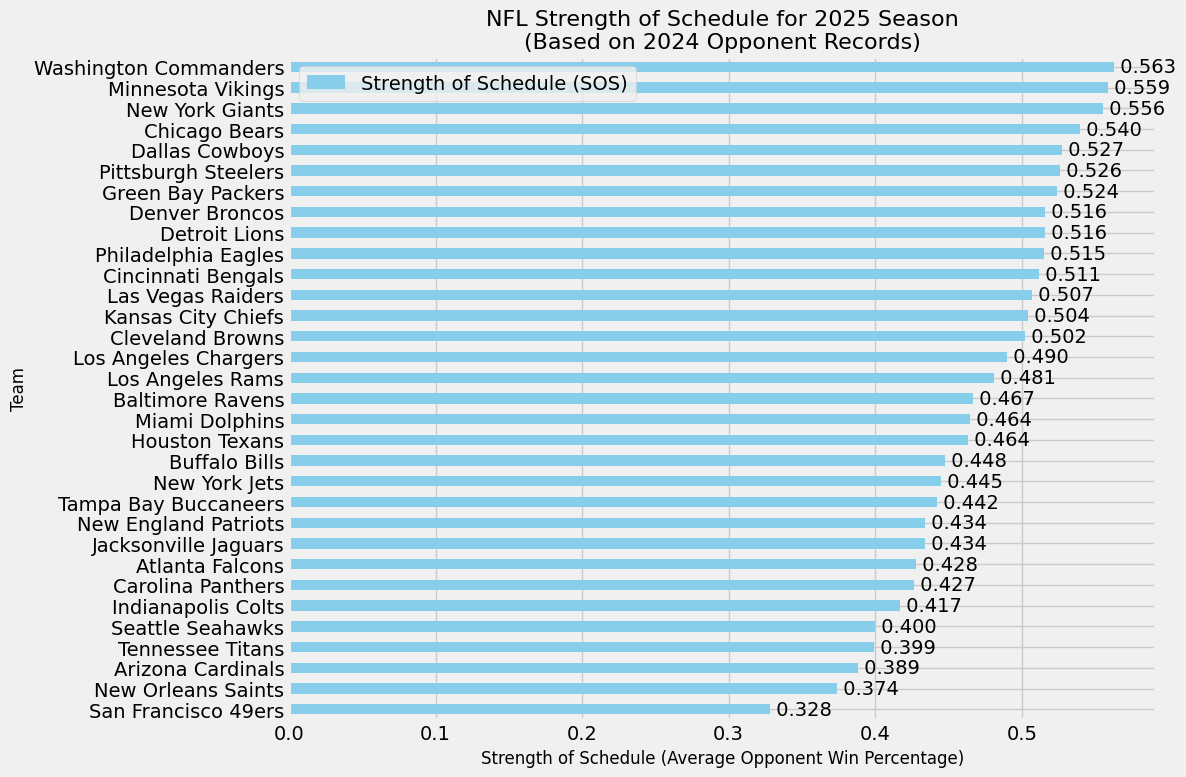

In [199]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Read your schedule file ---
# This line assumes 'nfl_schedule_2025.csv' is in the same folder as this script.
schedule_df = pd.read_csv('nfl_schedule_2025.csv')
print("Original Schedule Data:")
print(schedule_df.head())
print("-" * 50)

# --- Step 2: Read 2024 game data from nflverse repository ---
GAMES_URL = 'https://raw.githubusercontent.com/nflverse/nfldata/master/data/games.csv'
games_df = pd.read_csv(GAMES_URL)
games_df = games_df[games_df['season'] == 2024]
print("2024 Games Data:")
print(games_df.head())
print("-" * 50)

# Map team names to abbreviations
team_abbreviations = {
    'Washington Commanders': 'WAS', 'Green Bay Packers': 'GB', 'Cleveland Browns': 'CLE', 'Baltimore Ravens': 'BAL',
    'Jacksonville Jaguars': 'JAX', 'Cincinnati Bengals': 'CIN', 'New York Giants': 'NYG', 'Dallas Cowboys': 'DAL',
    'Chicago Bears': 'CHI', 'Detroit Lions': 'DET', 'New England Patriots': 'NE', 'Miami Dolphins': 'MIA',
    'San Francisco 49ers': 'SF', 'New Orleans Saints': 'NO', 'Buffalo Bills': 'BUF', 'New York Jets': 'NYJ',
    'Seattle Seahawks': 'SEA', 'Pittsburgh Steelers': 'PIT', 'Los Angeles Rams': 'LAR', 'Tennessee Titans': 'TEN',
    'Carolina Panthers': 'CAR', 'Arizona Cardinals': 'ARI', 'Denver Broncos': 'DEN', 'Indianapolis Colts': 'IND',
    'Philadelphia Eagles': 'PHI', 'Kansas City Chiefs': 'KC', 'Atlanta Falcons': 'ATL', 'Minnesota Vikings': 'MIN',
    'Tampa Bay Buccaneers': 'TB', 'Houston Texans': 'HOU', 'Los Angeles Chargers': 'LAC', 'Las Vegas Raiders': 'LV'
}

# --- Step 3: Calculate win percentage for each team ---
team_records = {}
for team_abbr in team_abbreviations.values():
    home_games = games_df[games_df['home_team'] == team_abbr]
    away_games = games_df[games_df['away_team'] == team_abbr]

    wins = (home_games['result'] > 0).sum() + (away_games['result'] < 0).sum()
    losses = (home_games['result'] < 0).sum() + (away_games['result'] > 0).sum()
    ties = (home_games['result'] == 0).sum()

    total_games = wins + losses + ties
    if total_games > 0:
        win_pct = (wins + 0.5 * ties) / total_games
    else:
        win_pct = 0.0
    team_records[team_abbr] = win_pct

records_df = pd.DataFrame(team_records.items(), columns=['team_abbr', 'win_pct'])

# --- Step 4: Prepare the schedule for calculation ---
schedule_df['Away_abbr'] = schedule_df['Away Team'].map(team_abbreviations)
schedule_df['Home_abbr'] = schedule_df['Home Team'].map(team_abbreviations)

schedule_with_opp_win_pct = schedule_df.merge(
    records_df,
    left_on='Away_abbr',
    right_on='team_abbr',
    how='left',
    suffixes=('', '_away_opp_win_pct')
).rename(columns={'win_pct': 'Away_Opp_Win_Pct'}).drop(columns='team_abbr')

schedule_with_opp_win_pct = schedule_with_opp_win_pct.merge(
    records_df,
    left_on='Home_abbr',
    right_on='team_abbr',
    how='left',
    suffixes=('', '_home_opp_win_pct')
).rename(columns={'win_pct': 'Home_Opp_Win_Pct'}).drop(columns='team_abbr')

# --- Step 5: Calculate Strength of Schedule (SOS) for each team ---
sos_scores = {}
for team_name in schedule_df['Away Team'].unique():
    team_games = schedule_with_opp_win_pct[
        (schedule_with_opp_win_pct['Away Team'] == team_name) |
        (schedule_with_opp_win_pct['Home Team'] == team_name)
    ]

    opponents_win_pcts = []
    for index, row in team_games.iterrows():
        if row['Away Team'] == team_name:
            opponents_win_pcts.append(row['Home_Opp_Win_Pct'])
        else:
            opponents_win_pcts.append(row['Away_Opp_Win_Pct'])

    if opponents_win_pcts:
        sos = sum(opponents_win_pcts) / len(opponents_win_pcts)
    else:
        sos = 0.0

    sos_scores[team_name] = sos

sos_df = pd.DataFrame(sos_scores.items(), columns=['Team', 'Strength of Schedule (SOS)'])
sos_df = sos_df.sort_values(by='Strength of Schedule (SOS)', ascending=False).reset_index(drop=True)

print("Final Strength of Schedule (SOS) Rankings:")
print(sos_df)

# --- Step 6: Plot the results ---
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 8))
sos_df.plot(kind='barh', x='Team', y='Strength of Schedule (SOS)', ax=ax, color='skyblue')

ax.set_title(f"NFL Strength of Schedule for 2025 Season\n(Based on 2024 Opponent Records)", fontsize=16)
ax.set_xlabel("Strength of Schedule (Average Opponent Win Percentage)", fontsize=12)
ax.set_ylabel("Team", fontsize=12)

# Invert y-axis to show highest SOS at the top
ax.invert_yaxis()

# Add SOS values as text labels on the bars
for index, value in enumerate(sos_df['Strength of Schedule (SOS)']):
    ax.text(value, index, f' {value:.3f}', va='center')

plt.tight_layout()
plt.savefig('strength_of_schedule.png')

In [223]:
import pandas as pd
import numpy as np

# Define a simple fantasy roster structure
ROSTER_SIZE = {'QB': 2, 'RB': 2, 'WR': 2, 'TE': 1, 'FLEX': 2, 'K': 1, 'DEF': 1, 'BENCH': 6}
ALL_POSITIONS = ['QB', 'RB', 'WR', 'TE', 'FLEX', 'K', 'DEF', 'BENCH']
FLEX_ELIGIBLE = ['RB', 'WR', 'TE']

available_players = names = [
    "Ja'Marr Chase", "Saquon Barkley", "Bijan Robinson", "Justin Jefferson", "Jahmyr Gibbs",
    "CeeDee Lamb", "Derrick Henry", "Nico Collins", "Puka Nacua", "Malik Nabers",
    "Brian Thomas Jr.", "Ashton Jeanty", "Amon-Ra St. Brown", "Christian McCaffrey", "A.J. Brown",
    "Jonathan Taylor", "De'Von Achane", "Drake London", "Josh Jacobs", "Brock Bowers",
    "George Kittle", "Bucky Irving", "Ladd McConkey", "Kyren Williams", "Josh Allen",
    "Lamar Jackson", "Tee Higgins", "Chase Brown", "Mike Evans", "Trey McBride",
    "Tyreek Hill", "Davante Adams", "Jaxon Smith-Njigba", "Jayden Daniels", "James Cook",
    "Jalen Hurts", "Breece Hall", "Garrett Wilson", "Marvin Harrison Jr.", "Terry McLaurin",
    "Kenneth Walker III", "Omarion Hampton", "Chuba Hubbard", "Joe Burrow", "DK Metcalf",
    "James Conner", "Alvin Kamara", "Jameson Williams", "DJ Moore", "Courtland Sutton",
    "Zay Flowers", "David Montgomery", "Xavier Worthy", "DeVonta Smith", "TreVeyon Henderson",
    "George Pickens", "D'Andre Swift", "Sam LaPorta", "Calvin Ridley", "Patrick Mahomes II",
    "Jaylen Waddle", "Tetairoa McMillan", "Rashee Rice", "Isiah Pacheco", "RJ Harvey",
    "Tony Pollard", "Aaron Jones Sr.", "Kaleb Johnson", "Mark Andrews", "Joe Mixon",
    "Baker Mayfield", "Brian Robinson Jr.", "Travis Hunter", "Bo Nix", "T.J. Hockenson",
    "Kyler Murray", "Chris Olave", "Rome Odunze", "Jerry Jeudy", "Tyrone Tracy Jr.",
    "Travis Kelce", "Justin Fields", "Jordan Addison", "Jayden Reed", "Dak Prescott",
    "Deebo Samuel Sr.", "Jaylen Warren", "Brock Purdy", "Jordan Mason", "Ricky Pearsall",
    "Tucker Kraft", "David Njoku", "Justin Herbert", "Jauan Jennings", "Chris Godwin",
    "Jakobi Meyers", "Travis Etienne Jr.", "Caleb Williams", "Evan Engram", "Jared Goff",
    "Stefon Diggs", "Drake Maye", "Rhamondre Stevenson", "Javonte Williams", "Tank Bigsby",
    "Najee Harris", "Jordan Love", "Khalil Shakir", "Tyler Warren", "Zach Charbonnet",
    "J.K. Dobbins", "Josh Downs", "Cam Skattebo", "Emeka Egbuka", "Tyjae Spears",
    "Trevor Lawrence", "Dalton Kincaid", "C.J. Stroud", "Dallas Goedert", "Cooper Kupp",
    "Quinshon Judkins", "Darnell Mooney", "Brandon Aiyuk", "Michael Pittman Jr.", "Kyle Pitts Sr.",
    "Keon Coleman", "Rachaad White", "Ray Davis", "Matthew Golden", "Rashod Shaheed",
    "J.J. McCarthy", "Colston Loveland", "Jake Ferguson", "Tua Tagovailoa", "Trey Benson",
    "Tyler Allgeier", "Rashod Bateman", "Christian Kirk", "Isaac Guerendo", "Austin Ekeler",
    "Jerome Ford", "Jonnu Smith", "Matthew Stafford", "Bryce Young", "Braelon Allen",
    "Jaydon Blue", "Jaylen Wright", "Marvin Mims Jr.", "Hunter Henry", "Nick Chubb",
    "Luther Burden III", "Michael Penix Jr.", "Rico Dowdle", "Cedric Tillman", "Denver Broncos",
    "Marquise Brown", "Tre' Harris", "Romeo Doubs", "Zach Ertz", "Isaiah Likely",
    "Dylan Sampson", "Roschon Johnson", "Bhayshul Tuten", "Quentin Johnston", "Adam Thielen",
    "Geno Smith", "Jayden Higgins", "Philadelphia Eagles", "Jalen McMillan", "Kyle Williams",
    "Pittsburgh Steelers", "Blake Corum", "Baltimore Ravens", "Xavier Legette", "Minnesota Vikings",
    "MarShawn Lloyd", "DeAndre Hopkins", "Sam Darnold", "DeMario Douglas", "Joshua Palmer",
    "Cameron Ward", "Alec Pierce", "Brenton Strange", "Houston Texans", "Brandon Aubrey",
    "Buffalo Bills", "Kansas City Chiefs", "Wan'Dale Robinson", "Detroit Lions", "Pat Freiermuth",
    "Jake Bates", "Cameron Dicker", "Cade Otton", "Jalen Coker", "Kendre Miller",
    "Keenan Allen", "Jack Bech", "Mike Gesicki", "Michael Wilson", "Los Angeles Chargers",
    "Los Angeles Rams", "Seattle Seahawks", "Chig Okonkwo", "Ka'imi Fairbairn", "Wil Lutz",
    "Chris Boswell", "Aaron Rodgers", "Kareem Hunt", "Chase McLaughlin", "Adonai Mitchell",
    "Kyle Monangai", "Dontavion Wicks", "Green Bay Packers", "Darius Slayton", "Miles Sanders",
    "New York Jets", "Harrison Butker", "Mason Taylor", "Evan McPherson", "Will Shipley",
    "Dalton Schultz", "Calvin Austin III", "Anthony Richardson Sr.", "Andrei Iosivas", "DJ Giddens",
    "Tyler Bass", "Justice Hill", "Devin Neal", "Jake Elliott", "Keaton Mitchell",
    "Jaylin Noel"
]
all_players_df = pd.DataFrame(names, columns=['Name'])
sos_df = sos_df
seventeen_games_df = df_latest

df2_unique = seventeen_games_df.drop_duplicates(subset=['player_display_name'], keep='first')
all_players_df = pd.merge(
    all_players_df,
    df2_unique[['player_display_name', 'player_id']], # Select only the columns you need from df2
    left_on='Name',
    right_on='player_display_name',
    how='left'
)
